## **Udacity: Introduction to TensorFlow for Deep Learning**

**Lesson 8 PART 3**

This lessons was an introduction to time series analysis, in particular time series forecasting.

Concepts introduced
- Definition of time series
- Application and patterns in time series


## **Import Dependencies**


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

print(tf.__version__)

2.7.0


## **Get the dataset from the previous collab notebook**

The instructor re-uses the same dataset and code from previous sections of the lesson. I need to add them back in, to this notebook.

In [2]:
# define the trend function
def trend(time, slope=0):
  """Function returns a time series with the specified slope."""
  return slope*time


# define the seasonality function
def seasonal_pattern(time_step):
  """Returns the output of a trig function."""
  return np.where(time_step < 0.4,
                  np.cos(time_step * 2 * np.pi),
                  1 / np.exp(3 * time_step))

def seasonality(time, period, amplitude, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


# define a function to add the white noise
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


# define function to plot the time series
def plot_series(time, series, format='-', start=0, end=None, label=None):
  """Plots a time series on a graph.
  Args
    - time (1d array): contains time steps for the series
    - series (1d array): contains values for the time series at each time step
  """
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)



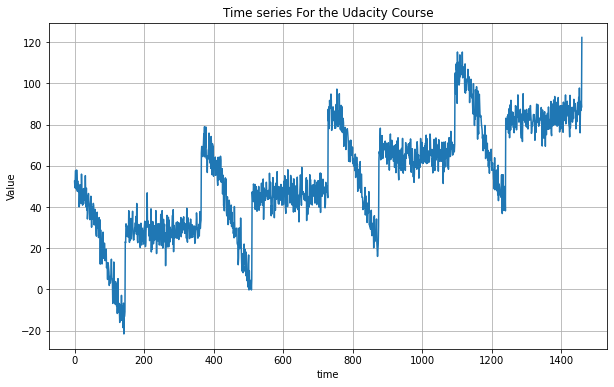

In [3]:
# define the time series
slope = 0.05
Period = 365
Max_amplitude = 40
noise_level = 5
baseline = 10

time = np.arange(4 * 365 + 1)
series = baseline + trend(time, slope) + seasonality(time, Period, Max_amplitude) + white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.title('Time series For the Udacity Course')
plt.show()


Split the time series into a training and validation set

In [4]:
Split_time = 1000

# Training period: 0 - 1000
x_train = series[:Split_time]
time_train = time[:Split_time]


# Validation period: 1000 - end
x_valid = series[Split_time:]
time_valid = time[Split_time:]


In [5]:
# define a function to run forecast on a time series
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast
  

##**Recurrent Neural Networks (RNN)**

A recurrent neural network is a network which contains a recurrent layer. Much like how a convolutional neural network is a network which contains a convolutional layer.

**Recurrent layer**   
A recurrent layer is a layer that can ***sequentially process a sequence of inputs***.
- A recurrent layer consist of a ***single memory cell (a simple neural network)*** which is used repeatedly to compute an output.
- These layers takes in sequenced data as input, process these series in sequence, to produce an output prediction and a state vector at each time step.
- **The state vector of the last time step is then feed back in as another input for the next time step.**
- **Typically the state vector is a copy of the output at that time step.**
- The dimension of the input data is 3 dimensional.
- [Batch size, window size, (1 for univariate, 2 or more for multivariate)]


### **Benefits and Drawbacks**
- As these layer use a single memory cell to process a sequence data. They can handle sequences of any length using a constant number of parameters.

- Meaning the number of parameters to optimize is not dependent on the size of the sequence data.

- RL have unstable gradients during training. The gradients can increase exponentially or vanish. To handle these unstable gradients, a tanh activation function is used.

- Training RNN can be very tricky, it would be useful to use a model checkpoint callback

- Good on training data with loads of high frequency and good signal to noise ratio.

### **Recurrent layer Example** 
- An input univariate data with 4 batches each with a window size of 30. The dimension of the input would be [4, 30, 1]

- At each time step the recurrent layer would recieve an input of size [4, 1]

- Assuming the memory cell is a simple dense layer with 5 neurons.

- The output at each time step is [4, 5]. Note that this excludes the 
state vector

- The full output of the layer after going through the whole sequenced data would be [4, 30, 5]

### **Deeper look, RL's as feedback control systsem**   
Typically a RL layer would take in a sequenced data as input and produce a sequenced data as output. For example an input data with a 7 window size
- $X =[x_{t_0}, x_{t_1}, x_{t_2}, x_{t_3}, x_{t_4}, x_{t_5}, x_{t_6}]$
- $y =[y_{t_0}, y_{t_1}, y_{t_2}, y_{t_3}, y_{t_4}, y_{t_5}, y_{t_6}]$

<br/>

But in a sequence to vector RL layer, the RL outputs the final value at the last time step. Example looking at the same batch
- $X =[x_{t_0}, x_{t_1}, x_{t_2}, x_{t_3}, x_{t_4}, x_{t_5}, x_{t_6}]$
- $y =y_{t_6}$

<br/>

Taking an input sequence and producing a single vector is the default behaviour of a RL in keras. Taking A deeper look at how a sequence to vector RL is used to forecast prediction.

<br/>

Looking at a single batch with a window size of 7.   

$$X = \begin{bmatrix}
                    2 & 4 & 6 & 8 & 10 & 12 & 14 \\
\end{bmatrix}$$
$$Y = \begin{bmatrix}
                    3.6 & 6.2 & 8 & 9.3 & 11.7 & 13.8 & 16.2 \\
\end{bmatrix}$$

Recap that at each time step, the RL produces a state vector which is fed back as input at the next time step. Now looking at the above example, At the first time step
- The input is 2 and the output is 3.6. The state vector would also be 3.6
- At the next time step, the state vector 3.6 and the input 4 is used to produce an output of 6.2
- Note also that the output at each time step closely mirrors the input at the next time step.

So the RL Uses the state vector as feedback to correct to prediction. The error in it's prediction being the difference between the input and the state vector. Much like how a feedback control system works. 😄😄😄

<br/>

Finally looking at the sequence, at the last time step the RL predicts the next value to be 16.2 which we know to be close to the actual value of 16.

<br/>

That's how a sequence to vector RL can be used to forecast values in a seqeunced data.

🤯🤯🤯🤯🤯🤯 That was a lot to take in.


## **Simple Sequence to vector RNN**

In [6]:
def window_dataset(series, window_size, batch_size=32):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  ds = ds.shuffle(len(series))
  return ds.batch(batch_size).prefetch(1)
  

In [7]:
# set random seeds inorder to get repeatable results
tf.random.set_seed(42)
np.random.seed(42)


# create the training and validation dataset
window_size = 30
train_set_ds = window_dataset(x_train, window_size)
valid_set_ds = window_dataset(x_valid, window_size)


In [9]:
# define a sequence to vector RNN
seq_vector_rnn = keras.models.Sequential([keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), # Add an extra dimension for the dimensionality of the dataset
                                 keras.layers.SimpleRNN(100, return_sequences=True),
                                 keras.layers.SimpleRNN(100),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x* 200) # Scale output by factor of 200. As tanh output values between -1 and 1. But time series have values within range of 40 - 160
                                 ])

# Compile the model by defining it's loss and optimizer and metric
seq_vector_rnn.compile(loss=keras.losses.Huber(),
                       optimizer=keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
                       metrics=["mae"])

seq_vector_rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 100)         10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [10]:
# define model training callbacks
# This is going to be annoying.

lr_schedule = keras.callbacks.LearningRateScheduler( lambda epoch: 1e-7 * 10**(epoch/20))

history = seq_vector_rnn.fit(train_set_ds, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 5s 57ms/step - loss: 40.9815 - mae: 41.4771 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 1s 45ms/step - loss: 21.2911 - mae: 21.7810 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 1s 44ms/step - loss: 18.3554 - mae: 18.8472 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 1s 45ms/step - loss: 16.5929 - mae: 17.0819 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 1s 45ms/step - loss: 15.5760 - mae: 16.0639 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 1s 44ms/step - loss: 14.8617 - mae: 15.3414 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 2s 45ms/step - loss: 14.2748 - mae: 14.7560 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 1s 45ms/step - loss: 13.8394 - mae: 14.3262 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 2s 46ms/step - loss: 13.6037 - mae:

KeyboardInterrupt: ignored

In [ ]:
# Plot the learning rate as a function of the loss to choose the most appropriate learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])


In [ ]:
# retrain the model with the selected learning rate
best_learning_rate = 10e-6


it's annoying having to retrain the model again. But at the very least i get some experience with using the learning rate scheduler

In [ ]:
# define the model
seq_vector_rnn_2 = keras.models.Sequential([keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                            keras.layers.SimpleRNN(100, return_sequences=True),
                                            keras.layers.SimpleRNN(100, return_sequences=True),
                                            keras.layers.Dense(1),
                                            keras.layers.Lambda(lambda x: x * 200.0)])

# compile the model
seq_vector_rnn_2.compile(loss=keras.losses.Huber(),
                         optimizer=keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
                         metrics=["mae"])

seq_vector_rnn_2.summary()


In [ ]:
# train the model

# define the model training callbacks
checkpoint = keras.callbacks.ModelCheckpoint(filepath="Checkpoint_model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# train the model on the training set and monitor its performance on the validation set
history = seq_vector_rnn_2.fit(train_set_ds, epochs=500,
                               validation_data=valid_set_ds,
                               callbacks=[checkpoint, early_stopping])

In [ ]:
# load the last best model
seq_vector_rnn_2_checkpoint_model = keras.models.load_model("Checkpoint_model.h5")


In [ ]:
# Use the last best model to run a forecast on the validation set

seq_vector_rnn_2_forecast = model_forecast( seq_vector_rnn_2_checkpoint_model,
                                           series[Split_time - window_size: -1],
                                           window_size)[:, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, seq_vector_rnn_2_forecast)

##**Sequence to Sequence RNN**

Training can be difficult as RNN can be viewed as a neural network with layers added each time step. 

Easier to train if the model makes a prediction at each time step. so y_predict = ne
- more gradient for training
- training occurs at each time steps
-

In [ ]:
# Define a function, which returns a dataset containing labels at at every timestep

def seq2seq_window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  series = tf.expand_dims(series, axis=-1) # add the extra dimension for the dimensionality of the data (1 for univariate 2 or more for multivariate)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:])) # label is now the next value for each time step
  return ds.batch(batch_size).prefetch(1)



In [ ]:
window_size = 30
train_set_seq2seq = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set_seq2seq = seq2seq_window_dataset(x_valid, window_size, batch_size=128)


In [ ]:
seq2seq_model = keras.models.Sequential([keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.SimpleRNN(100, return_sequences=True),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x* 200.0)])

In [ ]:
seq2seq_model.compile(loss=keras.losses.Huber(),
              optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
              metrics=["mae"])

seq2seq_model.summary()


In [ ]:
history = seq2seq_model.fit(train_set_seq2seq, epochs=500,
                            validation_data=valid_set_seq2seq,
                            callbacks=[early_stopping, checkpoint])


In [ ]:
# load the last best model
seq2seq_model_checkpoint = keras.models.load_model("Checkpoint_model.h5")

In [ ]:
seq2seq_model_forecast = model_forecast(seq2seq_model_checkpoint,
                                           series[Split_time - window_size: -1],
                                           window_size)[:, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, seq2seq_model_forecast)

## **Stateless and Stateful RNNs**

**Stateless RNN**   

***These are Recurrent neural networks that have been trained with randomly sampled batches of time windows at each epoch***. For example
- At epoch 1, the RNN would receive a batch containing 3 time windows taken at random positions alongs the time series.

The initial state of the RNN at each epoch would be 0 and after going through the time window, the state would be updated and then discarded at the end of the time window.

So far we have mainly been looking at stateless RNN. ***Stateless RNN are however limited by the size of the time series they can learn at each epoch***.To train RNN on larger window size. We would have to train the RNN in a differen way.

<br/>

**Stateful RNN**   
***For statefull RNN, the batches contain orderd sequences of time windows, as opposed to batches of randomly sampled time windows***.
Since the batch are orderd sequences of time windows, the states are not discarded but are passed from one batch to another, up untill you reach the end of the time series at which point the state is reset.

<br/>

**Significance of Statefull RNN**
- We can learn longer time series as, the states are passed from one batch to the other.
- The states are only reset once, you've reached the end of the time series, at this point you would simple loop back on the time series.
- Since the batch are orderd windows of time series. We would have to prepare the dataset in a slightly different way.

<br/>

**Key differences**   
- We would have to prepare the dataset in a different way. To get each batch to be an ordered sequence of time window.
- We would have to set the stateful flag to be True for the simple RNN.
- During the model training we would have to reset the state to 0 at the end of each epoch.

*Here we go*


In [6]:
# For statefull RNN we would have to prepare the dataset in a slightly different way

def sequential_window_dataset(series, window_size, shuffle_buffer=1000):
  series = tf.expand_dims(series, axis=-1)                                       # add the extra dimension for the dimensionality of the data (1 for univariate 2 or more for multivariate)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)        # shift each window by the window size
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  # ds = ds.shuffle(shuffle_buffer)                                              # no need to randomly sample the each batch
  ds = ds.map(lambda w: (w[:-1], w[1:]))                                         # label is now the next value for each time step
  return ds.batch(1).prefetch(1)                                        # set the batch size to equal 1 time window



In [7]:
# create the training and validation dataset
window_size = 30
stateful_RNN_train_set_ds = sequential_window_dataset(x_train, window_size)
stateful_RNN_valid_set_ds = sequential_window_dataset(x_valid, window_size)


In [8]:
# define the stateful sequence to sequence RNN

# Note that we would have to specifiy the batch size for the model
# This allows keras to know how many state vector to preserve between each training iteration.
seq2seq_stateful_RNN = keras.models.Sequential([
                                 keras.layers.SimpleRNN(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
                                 keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x*200.0)
])


In [9]:
# Compile the model
seq2seq_stateful_RNN.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
                             loss=keras.losses.Huber(),
                             metrics=["mae"])

seq2seq_stateful_RNN.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (1, None, 100)            10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (1, None, 100)            20100     
                                                                 
 dense (Dense)               (1, None, 1)              101       
                                                                 
 lambda (Lambda)             (1, None, 1)              0         
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [10]:
# we need to reset the states at the end of each epoch
# to do this we create a subclass of the keras.callback class which contains the
# on_epoch_begin methods, which calls the reset_states function.

class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

reset_states = ResetStatesCallback()


In [11]:
# define the model callbacks and fit the model on the time series
model_checkpoint = keras.callbacks.ModelCheckpoint("Seq2Seq_stateful_RNN.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

history = seq2seq_stateful_RNN.fit(stateful_RNN_train_set_ds, epochs=500,
                                    validation_data=stateful_RNN_valid_set_ds,
                                    callbacks=[early_stopping, model_checkpoint, reset_states])


Epoch 1/500
33/33 [==============================] - 5s 83ms/step - loss: 160.7706 - mae: 161.2696 - val_loss: 10.9805 - val_mae: 11.4658
Epoch 2/500
33/33 [==============================] - 2s 59ms/step - loss: 25.7578 - mae: 26.2540 - val_loss: 8.6238 - val_mae: 9.1062
Epoch 3/500
33/33 [==============================] - 2s 59ms/step - loss: 14.3624 - mae: 14.8500 - val_loss: 9.7523 - val_mae: 10.2427
Epoch 4/500
33/33 [==============================] - 2s 57ms/step - loss: 13.4503 - mae: 13.9337 - val_loss: 9.1821 - val_mae: 9.6701
Epoch 5/500
33/33 [==============================] - 2s 58ms/step - loss: 12.5938 - mae: 13.0822 - val_loss: 8.9722 - val_mae: 9.4600
Epoch 6/500
33/33 [==============================] - 2s 61ms/step - loss: 11.9318 - mae: 12.4162 - val_loss: 8.5436 - val_mae: 9.0324
Epoch 7/500
33/33 [==============================] - 2s 59ms/step - loss: 11.4483 - mae: 11.9355 - val_loss: 8.0212 - val_mae: 8.5103
Epoch 8/500
33/33 [==============================] - 2s 5

In [13]:
# load the save model
best_stateful_rnn = keras.models.load_model("Seq2Seq_stateful_RNN.h5")


In [14]:
# evaluate the saved model

# need to reset the state of the model before we make our prediction
best_stateful_rnn.reset_states()



In [21]:
# make a forecast on the full time series
best_stateful_rnn_model_full_dataset_forecast = best_stateful_rnn.predict(series[np.newaxis, :, np.newaxis])

# get the time period for the validation set which is what we are interested in
best_stateful_rnn_model_valid_dataset_forecast = best_stateful_rnn_model_full_dataset_forecast[0, Split_time -1: -1, 0]


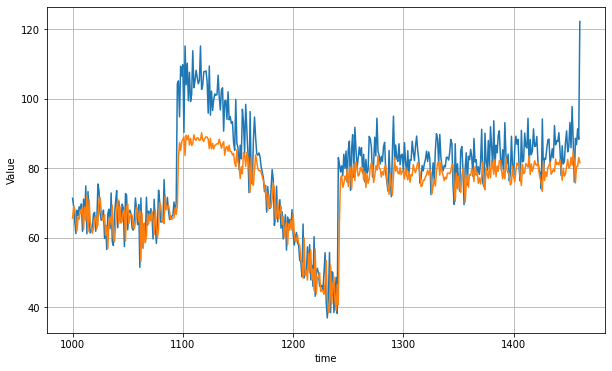

In [22]:
# plot the statefull rnn forecast on the validaton set

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, best_stateful_rnn_model_valid_dataset_forecast)

In [24]:
# calculate the MAE for the model
keras.metrics.mean_absolute_error(x_valid, best_stateful_rnn_model_valid_dataset_forecast).numpy()

6.862566

##**Long term short term memory (LSTM)**

Wow, there is so much topics covered in lesson 8
- Different types of patterns in time series data: Trend, seasonality and white noise.

- The different applications of time series analysis: Forecasting, imputing missing sections of time series data, understanding underlying structure of the time series.

- We focused on time series forecasting

- Naive forecasting method: same as input but just shifted by x amount

- Forecasting using a moving average: Done by taking the average value from the last x values

- Making better forecasting by removing the trend and seasonality

- Using centered and smoothing windows

- Introduced to RNN.

- learnt how to prepare data for RNN models

- Introduced to sequence to sequence RNN and sequence to vector RNN

- Introduced to stateful and stateless RNN. With stateful RNN used as a method to learn patterns over longer time periods.

<br/>

and Now..... 

....Deep breaths

Introducing the Long term short tem memory cells. These are cells that can learn patterns over even longer time periods, they lengthen the short term memory of the RNN. The implementation of these cells is similar to RNN. My focus would be on at least understanding the concepts introduced by these cells.


**Long term Short term memory cell**

Similar to RNN, LSTMs output state vector at each time step. Unlike RNN, it outputs 2 types of state vectors
- A long term state vector $C_{t}$
- A short term state vector $H_{t}$

The short term state vector, as already been introduced in RNNs, it's essentially a copy of the output $Y_{t}$. Note that the computation for the short term state vector is different from how it is calculated in the RNN. But the concept *it being a copy of the output* remains the state.

<br/>

The long term state vector goes through different layers of computation and is fundamentally different from the output and the short term state vector.

<br/>

**Computational layers in an LSTM cell**

The LSTM cell contains several "*gates*" which add or take away from the long term state vector.
- **Forget gate**. This gate learns which part of the long term state vector to forget.

- **Input gate**. This gate learns when to add new information to the long term state vector. So it learns when to remeber new information.

- **Output gate**. This gate learns which part of the long term state vector to use for the output & short term state vector for the next time step.

[Long term short term memory cell](https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/1280px-LSTM_Cell.svg.png)


**Implementing LSTMS**

Fundamentally there is no significant change in the code, the only difference is that an LSTM layer is selected from the keras.layer class and not a SimpleRNN.

## **Using CNNs for time series forecasting**

Convolutional neural networks can be used as preprocessing layers for RNN and LSTM networks. Alternatively a network architecture containing only convolutional layers can be implememted to forecast on time series.

<br/>

Towards using CNNs for time series forecasting, we would have to use convolutional layers with 1D filters (Conv1D). A convolutional layer with 2D filters slides across 2 dimensions width and height.

The 1D filter of a conv1D layer slides through each value in the time series to produce an output.

<br/>

**Conv1D parameters**

**Filter size**
- The filter size, determines the number of values it covers at each time steps. it's essentially the same as the window size we have seen before.

- For example with a filter size of 3, the filter would take in 3 values at each time step and use these 3 values to produce a single output.

<br/>

**Stride**
- The stride determines how much the filter is shifted at each time step.

- For example, with a stride of 1, the filter would be shifted by 1 and take values from the corresponding window.


<br/>

**Number of filters**
- As the 1D convolutional layer takes in values within it's filter size and outputs a single value at each time step. it takes in a sequence and output another sequence.

- The number of filter determines the dimensionality of the output sequence. 

- For example, if there are 5 filters in the 1D conv layer. There would 5 different output sequence produced from the initial input sequence.

<br/>

**Padding**

- Without any padding, the output sequence are usually the length of the input sequence - (filter size - 1). So if there are 5 time steps in the input sequence for a filter size of 3, the resulting output sequence would have only 3 time steps

- SAME padding, would add values to the left and right of the time series to ensure that the output sequence have the same number of time steps as the input sequence.

*We have seen this before with*

- Causual paddding. With the current structure of the 1D convolutional layer, the output value at each time step is calculated from values at the current time step and other future values.

- For example   
A conv1D layer with a filter size of 3 and a stride of 1.

$X = [x_{t_0}, x_{t_1}, x_{t_2}, x_{t_3}, x_{t_4}]$   
$Y_{t_0} = W_0 * x_{t_0} + W_1 * x_{t_1} + W_2 * x_{t_2} $   
$Y_{t_1} = W_0 * x_{t_1} + W_1 * x_{t_2} + W_2 * x_{t_3} $   
$Y_{t_2} = W_0 * x_{t_2} + W_1 * x_{t_3} + W_2 * x_{t_4} $   

we can see that the output value at each time step is calculated using value from the next few time steps.

- To prevent this casual padding, applies padding to the left of the time series to ensure that the output value at each time step is calculated from future values.

- Causal padding example

Without causual padding $X = [x_{t_0}, x_{t_1}, x_{t_2}, x_{t_3}, x_{t_4}]$.   
With causual padding $X = [0, 0, x_{t_0}, x_{t_1}, x_{t_2}, x_{t_3}, x_{t_4}]$   

$Y_{t_0} = W_0 * 0 + W_1 * 0 + W_2 * x_{t_1} $   
$Y_{t_1} = W_0 * 0 + W_1 * x_{t_0} + W_2 * x_{t_1} $   
$Y_{t_2} = W_0 * x_{t_0} + W_1 * x_{t_1} + W_2 * x_{t_2} $
